In [423]:
import numpy as np
import scipy.fft as sf
import scipy.signal as ss
import matplotlib.pyplot as plt
%matplotlib widget
import scipy

scipy.__version__

'1.12.0'

In [424]:
def plot_psd(noise, f_herz, m_tt="", nperseg=1024):
    freq, psdw_noise = ss.welch(noise,  window="hann", fs=f_herz, scaling="density", nperseg=nperseg)
    plt.figure()
    plt.title(m_tt)
    # remove mode 0 and Nyquist
    plt.loglog(freq[1:-2], psdw_noise[1:-2])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'PSD: [$U^2/Hz$]')
    plt.grid()


# PSD model: $[1+(f_k/f)^\alpha]\sigma^2$

Model of PSD noise with 1/f noise at "low frequency" and white noise at "high frequency". The transition between ""low and "high" frequencies is defined by $f_k$ named frequency knee.

0.0


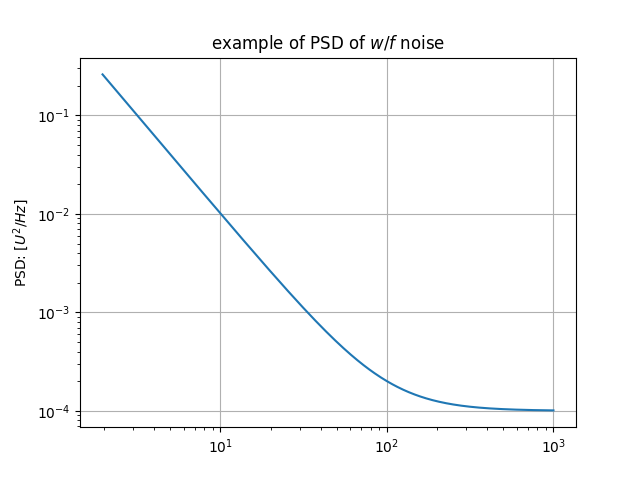

In [425]:
freq= np.linspace(0, 1000, 512)

def psd_1f_white(freq, sigma=1e-2, f_knee = 100, alpha = 2):
    # psd at 0 is 0
    psd = np.empty_like(freq)
    i_b = 0
    if freq[0] == 0:
        i_b = 1
        psd[0] = 0.0
    psd[i_b:] = (1 + np.power(f_knee/freq[i_b:],alpha ))*sigma**2
    return psd 

psd = psd_1f_white(freq)
print( psd[0])

plt.figure()
plt.title('example of PSD of $w/f$ noise')
plt.loglog(freq[1:], psd[1:])
plt.ylabel(r'PSD: [$U^2/Hz$]')
plt.grid()


# Generator of $w/f$ noise

## Method of coloring white noise

4 steps:
* create a white noise with normal random : w_n
* compute le FFT of w_n
* multiple it by sqrt(PSD)
* take the inverse FFT of the result

For FFT computation, we use the scipy implementation for real input signal, function `rfft()` with default normalization mode "backward", see [ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.rfft.html).


We will see that in this context the frequency of sampling of the white noise is important. Let's begin wihout normalization.

### With no normalization

In [426]:
n_s = 2048*8
f_s = 1500.0
f_n = f_s/2
w_noise = np.random.randn(n_s)
print(w_noise.mean(), w_noise.std())

0.01441589941497502 0.9942030069896547


In [427]:
fft_w = sf.rfft(w_noise)
n_freq = fft_w.shape[0]
freq_fft =  np.linspace(0.0, f_n, n_freq )
print(freq_fft)

[0.00000000e+00 9.15527344e-02 1.83105469e-01 ... 7.49816895e+02
 7.49908447e+02 7.50000000e+02]


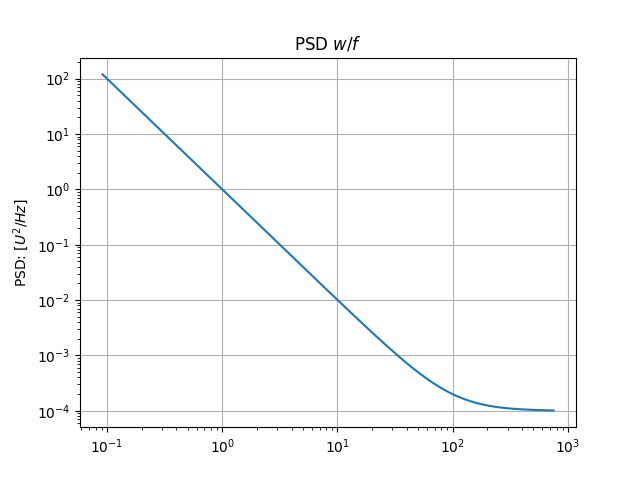

In [428]:
psd_i = psd_1f_white(freq_fft)
plt.figure()
plt.title('PSD $w/f$')
plt.loglog(freq_fft[1:-2], psd_i[1:-2])
plt.ylabel(r'PSD: [$U^2/Hz$]')
plt.grid()

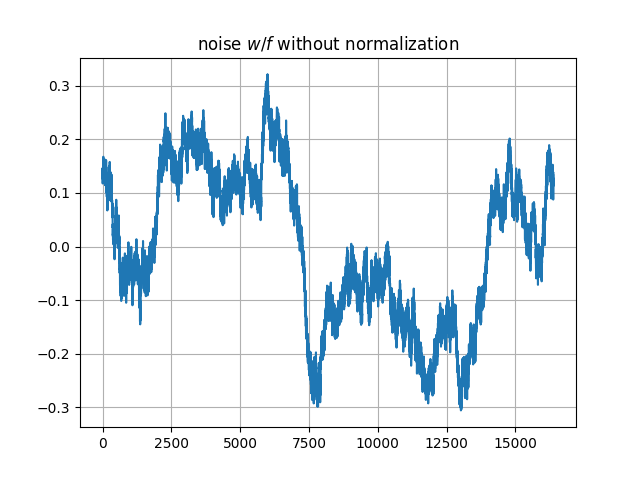

In [429]:
fft_c = fft_w*np.sqrt(psd_i)
noise_c = sf.irfft(fft_c)
plt.figure()
plt.title('noise $w/f$ without normalization')
plt.plot(noise_c)
plt.grid()

now it's PSD with Welch method provided by SciPy

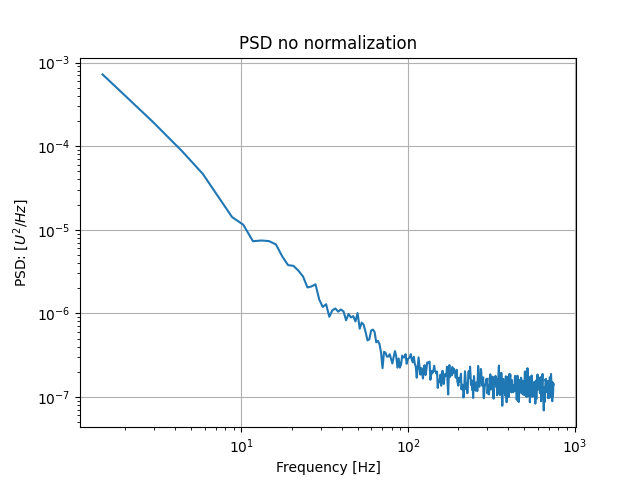

In [430]:
plot_psd(noise_c, f_s,"PSD no normalization")

The flat part of PSD isn't 1e-4 as expected. Apply the "PSD normalization" factor   

### With normalization $\sqrt{\frac{f_s}{2}}$

In [431]:
# PSD normalization
fft_c *= np.sqrt(f_s/2)
noise_cn = sf.irfft(fft_c)

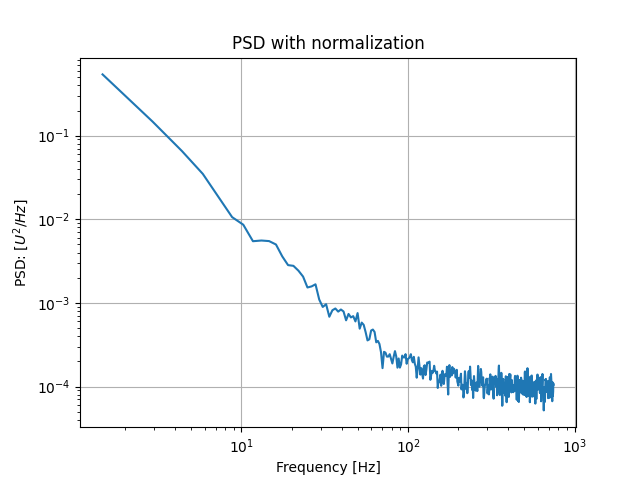

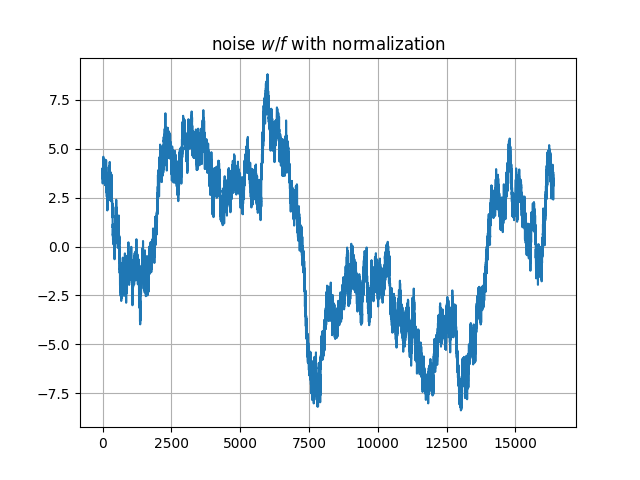

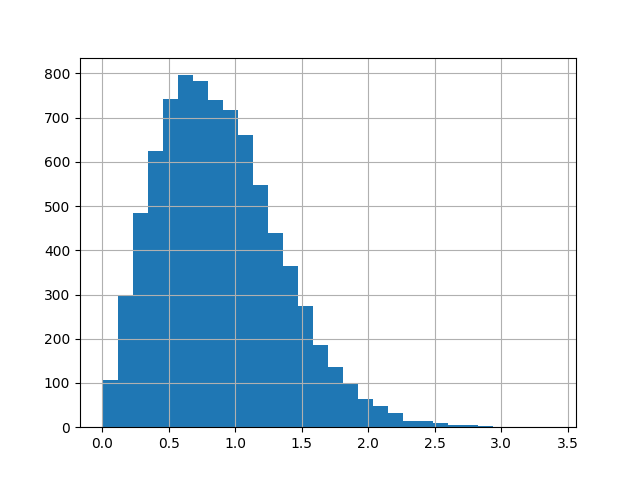

In [432]:
plot_psd(noise_cn, f_s,"PSD with normalization")

plt.figure()
plt.title('noise $w/f$ with normalization')
plt.plot(noise_cn)
plt.grid()

plt.figure()
plt.hist(np.abs(fft_w/np.sqrt(n_s)), 30)
plt.grid()

Now the PSD has the right value for the high frequency.

## Fast method with only inverse FFT

It's possible to improve the previous method whitout generate a normal noise in direct space. We define the FFT of the colored noise in polar representation where the module is the ASD and the phase in uniform random value.



In [433]:
n_s = 2048*8
f_s = 1500.0
f_n = f_s/2

freq = sf.rfftfreq(n_s, 1/f_s)
modul = np.sqrt(psd_1f_white(freq))
angle = np.random.uniform(0,2*np.pi, len(freq))
fft_c = modul*np.exp(1j*angle)
fft_c *= np.sqrt(n_s)
fft_c *= np.sqrt(f_s/2)
noise_fast = sf.irfft(fft_c)

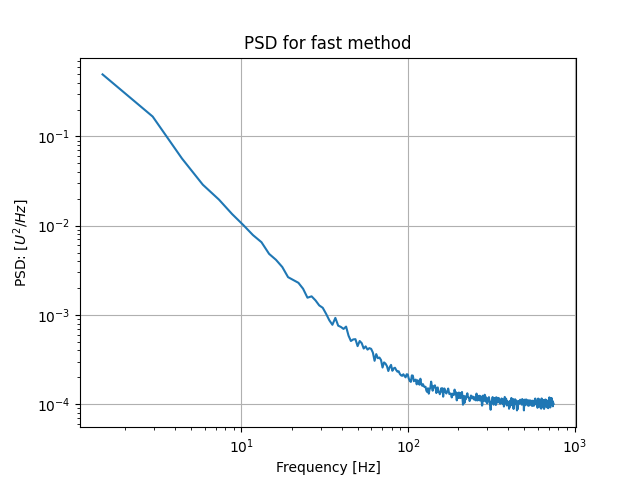

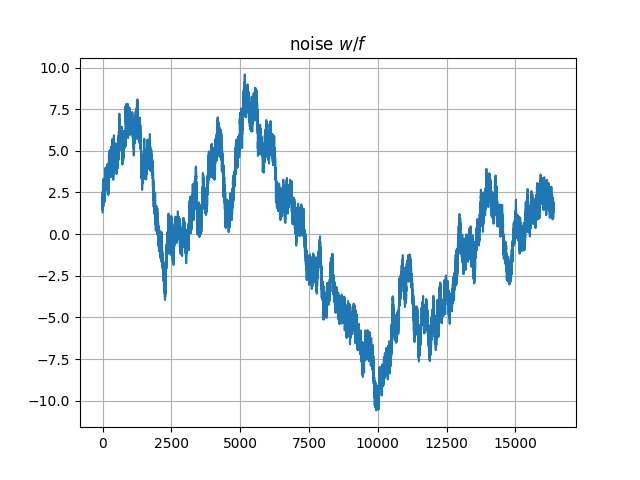

In [434]:
plot_psd(noise_fast, f_s, "PSD for fast method")

plt.figure()
plt.title('noise $w/f$')
plt.plot(noise_fast)
plt.grid()

# Comparaison


float64 (16384,)


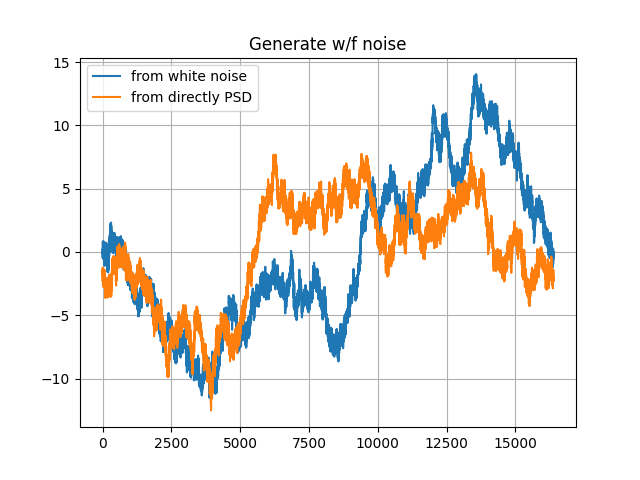

In [ ]:
def generate_from_wnoise(psd, n_s, f_s):
    # PSD normalisation : sqrt(f_s/2)
    w_noise = np.random.randn(n_s)
    fft_w = sf.rfft(w_noise)
    fft_w *= np.sqrt(psd*f_s/2)
    return sf.irfft(fft_w)

def generate_from_psd(psd, n_s,f_s):
    angle = np.random.uniform(0,2*np.pi, len(psd))
    # PSD normalisation : sqrt(f_s/2)
    # SciPy FFT forward normalisation : sqrt(n_s)
    fft_c = np.exp(1j*angle)*np.sqrt(psd*(n_s*f_s/2))
    return sf.irfft(fft_c)

n_s = 2048*8
f_s = 1500.0

freq = sf.rfftfreq(n_s, 1/f_s)
psd = psd_1f_white(freq)

n_wnoise = generate_from_wnoise(psd, n_s, f_s)
n_psd = generate_from_psd(psd, n_s,f_s)
print(n_psd.dtype, n_psd.shape)
plt.figure()
plt.title("Generate w/f noise")
plt.plot(n_wnoise, label="from white noise")
plt.plot(n_psd, label="from directly PSD")
plt.grid()
plt.legend()

In [449]:
%timeit generate_from_wnoise(psd, n_s, f_s)


454 µs ± 2.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [450]:
%timeit generate_from_psd(psd, n_s, f_s)

380 µs ± 7.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [451]:
455/372

1.2231182795698925